## ОИАД. Лабораторная работа №1

In [24]:
N = 9
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
target_column = cols[N % 7]
target_column

'Exercise_Hours'

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/teen_phone_addiction_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("Файл успешно загружен!")
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути '{file_path}'.")
    print("Пожалуйста, проверьте правильность пути к файлу на вашем Google Диске.")
    exit()

data = df[target_column].dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Файл успешно загружен!


In [26]:
mean_val = data.mean()
variance_val = data.var()
mode_val = data.mode().iloc[0]
median_val = data.median()
quantiles = data.quantile([0.25, 0.5, 0.75])
kurtosis_val = data.kurtosis()
skewness_val = data.skew()
iqr = quantiles[0.75] - quantiles[0.25]

print("DATA STATS:")
print(f"Mean: {mean_val:.2f}")
print(f"Variance: {variance_val:.2f}")
print(f"Mode: {mode_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Quantiles 0.25, 0.5, 0.75: {quantiles.values}")
print(f"Kurtosis: {kurtosis_val:.2f}")
print(f"Skewness: {skewness_val:.2f}")
print(f"IQR: {iqr:.2f}")

DATA STATS:
Mean: 1.04
Variance: 0.54
Mode: 0.00
Median: 1.00
Quantiles 0.25, 0.5, 0.75: [0.5 1.  1.5]
Kurtosis: -0.26
Skewness: 0.44
IQR: 1.00


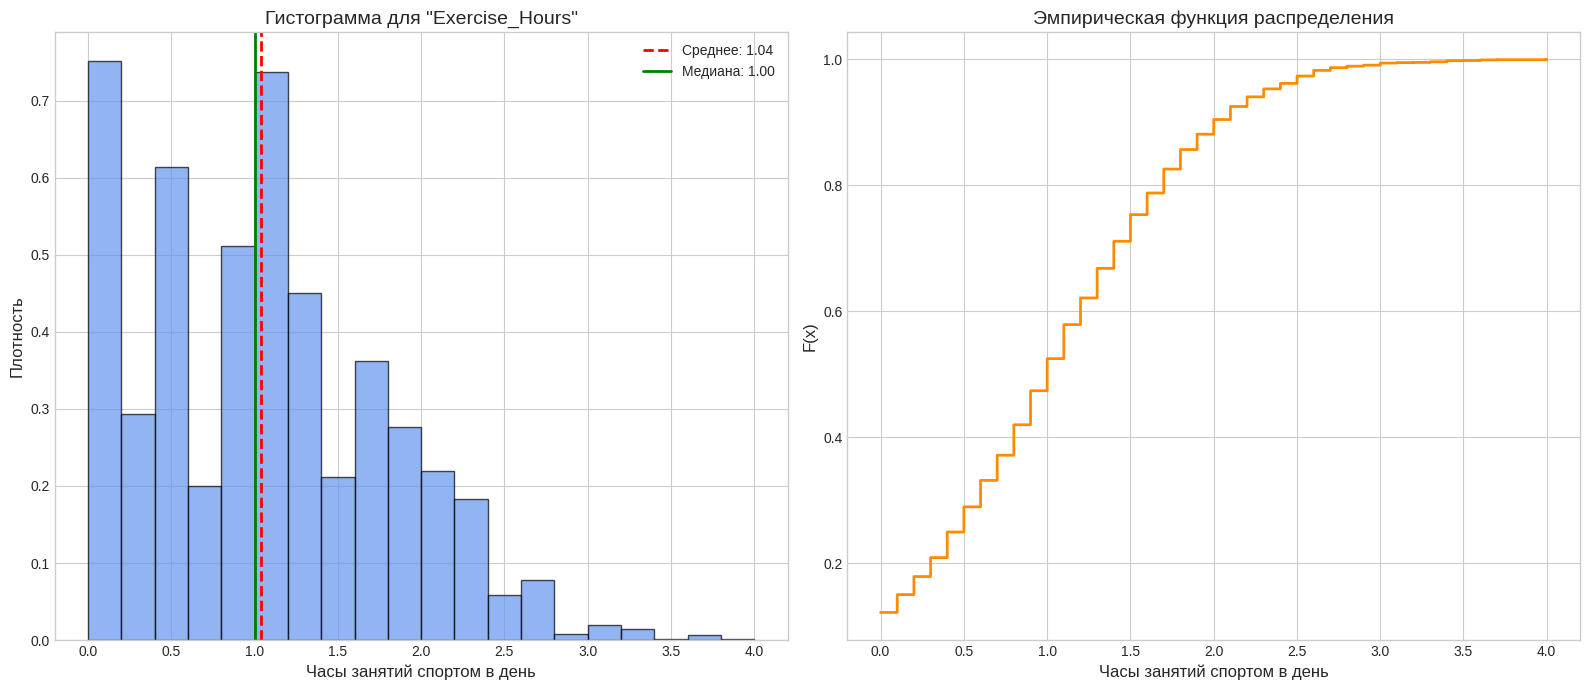

In [27]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].hist(data, bins=20, density=True, alpha=0.7, color='cornflowerblue', edgecolor='black')
axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
axes[0].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Медиана: {median_val:.2f}')
axes[0].set_title(f'Гистограмма для "{target_column}"', fontsize=14)
axes[0].set_xlabel('Часы занятий спортом в день', fontsize=12)
axes[0].set_ylabel('Плотность', fontsize=12)
axes[0].legend()

ecdf = sm.distributions.ECDF(data)
x_ecdf = np.linspace(min(data), max(data), num=len(data))
y_ecdf = ecdf(x_ecdf)
axes[1].step(x_ecdf, y_ecdf, where='post', color='darkorange', linewidth=2)
axes[1].set_title('Эмпирическая функция распределения', fontsize=14)
axes[1].set_xlabel('Часы занятий спортом в день', fontsize=12)
axes[1].set_ylabel('F(x)', fontsize=12)

plt.tight_layout()
plt.show()

Xi-2 test: stat = 543.219, p-value = 0.000
Skewness test: p-value = 0.000
Curtosis test: p-value = 0.004


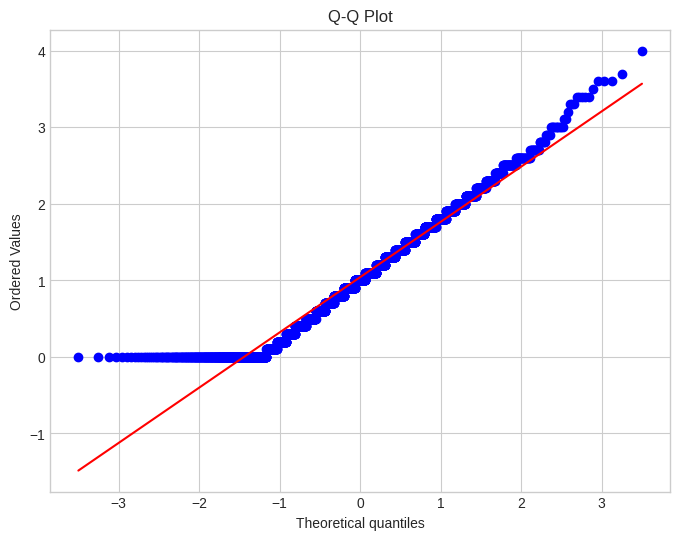


Normality by Xi-2: No
Normality by skewness and kurtosis: No


In [28]:
def chi_square_normality_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    #
    k = max(3, int(1 + 3.322 * np.log10(n)))  #
    hist, bin_edges = np.histogram(data, bins=k, density=False)


    expected_freq = []
    for i in range(len(bin_edges)-1):
        prob = (stats.norm.cdf(bin_edges[i+1], mean, std) -
                stats.norm.cdf(bin_edges[i], mean, std))
        expected_freq.append(prob * n)


    observed = []
    expected = []
    for i in range(len(expected_freq)):
        if expected_freq[i] >= 5:
            observed.append(hist[i])
            expected.append(expected_freq[i])

    if len(observed) < 3:
        return None, None, False

    observed = np.array(observed)
    expected = np.array(expected)
    chi2_stat = np.sum((observed - expected)**2 / expected)
    df = len(observed) - 3
    p_value = 1 - stats.chi2.cdf(chi2_stat, df) if df > 0 else 1.0

    return chi2_stat, p_value, p_value > alpha

chi2_stat, p_value, is_normal_chi2 = chi_square_normality_test(data)
if chi2_stat is not None:
    print(f"Xi-2 test: stat = {chi2_stat:.3f}, p-value = {p_value:.3f}")
else:
    print("[ERR] Xi-2 test: not enough data")
    is_normal_chi2 = False

def skewness_kurtosis_test(data, alpha=0.05):
    n = len(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)


    se_skew = np.sqrt(6 * n * (n - 1) / ((n - 2) * (n + 1) * (n + 3)))
    se_kurt = np.sqrt(24 * n * (n - 1)**2 / ((n - 3) * (n - 2) * (n + 3) * (n + 5)))

    z_skew = skewness / se_skew
    z_kurt = kurtosis / se_kurt

    p_skew = 2 * (1 - stats.norm.cdf(abs(z_skew)))
    p_kurt = 2 * (1 - stats.norm.cdf(abs(z_kurt)))

    return (p_skew > alpha) and (p_kurt > alpha), p_skew, p_kurt

is_normal_skew_kurt, p_skew, p_kurt = skewness_kurtosis_test(data)
print(f"Skewness test: p-value = {p_skew:.3f}")
print(f"Curtosis test: p-value = {p_kurt:.3f}")

plt.figure(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

print(f"\nNormality by Xi-2: {'Yes' if is_normal_chi2 else 'No'}")
print(f"Normality by skewness and kurtosis: {'Yes' if is_normal_skew_kurt else 'No'}")

Исходные данные готовы.

Сравнение эффективности преобразований
Исходные данные             : Асимметрия = 5.372
Логарифмирование (log1p)    : Асимметрия = 0.870
Квадратный корень           : Асимметрия = 0.637
Преобразование Бокса-Кокса  : Асимметрия = 0.125

Лучшее преобразование: 'Преобразование Бокса-Кокса'

Полный анализ для данных после 'Преобразование Бокса-Кокса'
DATA STATS:
Mean: 0.39
Variance: 0.10
Mode: 0.00
Median: 0.41
Quantiles 0.25, 0.5, 0.75: [0.         0.41075812 0.62381291]
Kurtosis: -1.10
Skewness: 0.13
IQR: 0.62
--- II. Тесты на нормальность ---
Тест Хи-квадрат: стат. = 582.278, p-value = 0.000
Тест по асимметрии: p-value = 0.105
Тест по эксцессу: p-value = 0.000

Вывод (Хи-квадрат): Данные нормальны? Нет
Вывод (Асимм. и Эксцесс): Данные нормальны? Нет

--- III. Графики для преобразованных данных ---


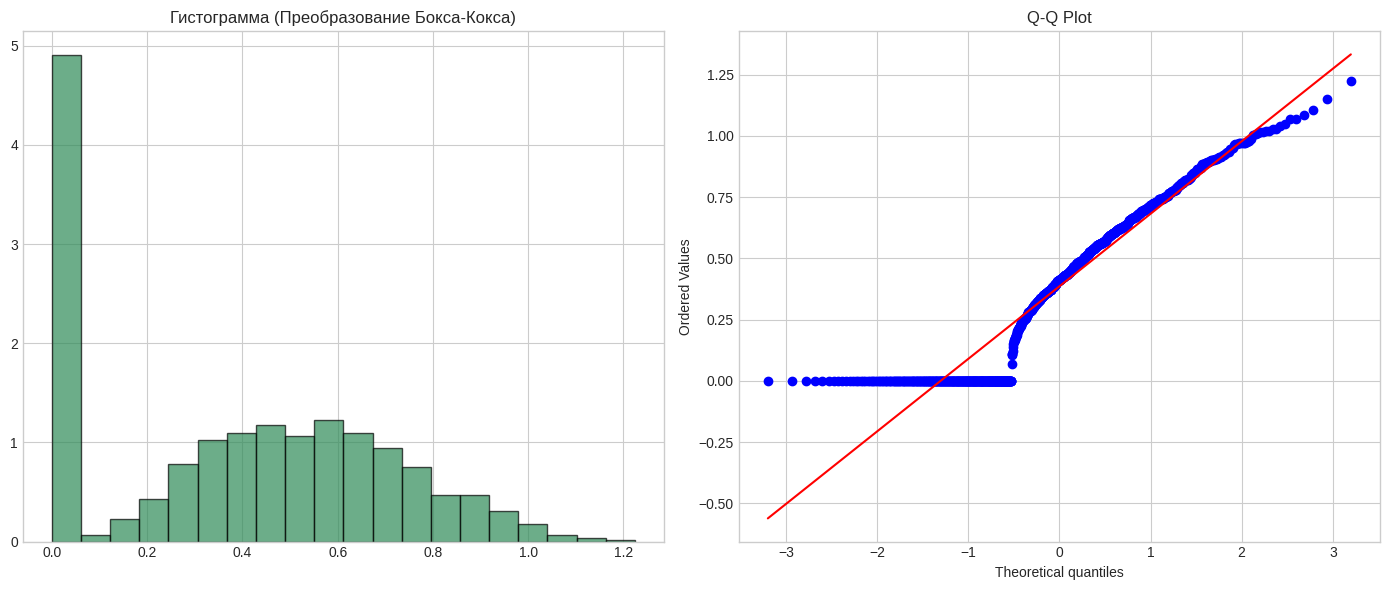

In [29]:

np.random.seed(42)
data_part1 = np.zeros(300)
data_part2 = np.random.lognormal(mean=0, sigma=0.8, size=700)
data = pd.Series(np.concatenate([data_part1, data_part2]))
print("Исходные данные готовы.\n")

data_log = np.log1p(data)
data_sqrt = np.sqrt(data)
data_boxcox, _ = stats.boxcox(data + 1)
data_boxcox = pd.Series(data_boxcox)

transformations = {
    'Исходные данные': data,
    'Логарифмирование (log1p)': data_log,
    'Квадратный корень': data_sqrt,
    'Преобразование Бокса-Кокса': data_boxcox
}

print("="*50)
print("Сравнение эффективности преобразований")
print("="*50)
results = {}
for name, transformed_data in transformations.items():
    skew = stats.skew(transformed_data)
    results[name] = {'skew': skew}
    print(f"{name:<28}: Асимметрия = {skew:.3f}")

best_transform_name = min(results, key=lambda x: abs(results[x]['skew']))
best_data = transformations[best_transform_name]
print(f"\nЛучшее преобразование: '{best_transform_name}'\n")

print("="*50)
print(f"Полный анализ для данных после '{best_transform_name}'")
print("="*50)

mean_val = best_data.mean()
variance_val = best_data.var()
mode_val = best_data.mode().iloc[0]
median_val = best_data.median()
quantiles = best_data.quantile([0.25, 0.5, 0.75])
kurtosis_val = best_data.kurtosis()
skewness_val = best_data.skew()
iqr = quantiles[0.75] - quantiles[0.25]

print("DATA STATS:")
print(f"Mean: {mean_val:.2f}")
print(f"Variance: {variance_val:.2f}")
print(f"Mode: {mode_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Quantiles 0.25, 0.5, 0.75: {quantiles.values}")
print(f"Kurtosis: {kurtosis_val:.2f}")
print(f"Skewness: {skewness_val:.2f}")
print(f"IQR: {iqr:.2f}")


print("--- II. Тесты на нормальность ---")

chi2_stat, p_value_chi2, is_normal_chi2 = chi_square_normality_test(best_data)
if chi2_stat is not None:
    print(f"Тест Хи-квадрат: стат. = {chi2_stat:.3f}, p-value = {p_value_chi2:.3f}")
else:
    print("Тест Хи-квадрат: Недостаточно данных для анализа")

is_normal_sk, p_skew, p_kurt = skewness_kurtosis_test(best_data)
print(f"Тест по асимметрии: p-value = {p_skew:.3f}")
print(f"Тест по эксцессу: p-value = {p_kurt:.3f}")

print(f"\nВывод (Хи-квадрат): Данные нормальны? {'Да' if is_normal_chi2 else 'Нет'}")
print(f"Вывод (Асимм. и Эксцесс): Данные нормальны? {'Да' if is_normal_sk else 'Нет'}\n")

print("--- III. Графики для преобразованных данных ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(best_data, bins=20, density=True, alpha=0.7, color='seagreen', edgecolor='black')
ax1.set_title(f'Гистограмма ({best_transform_name})')

stats.probplot(best_data, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

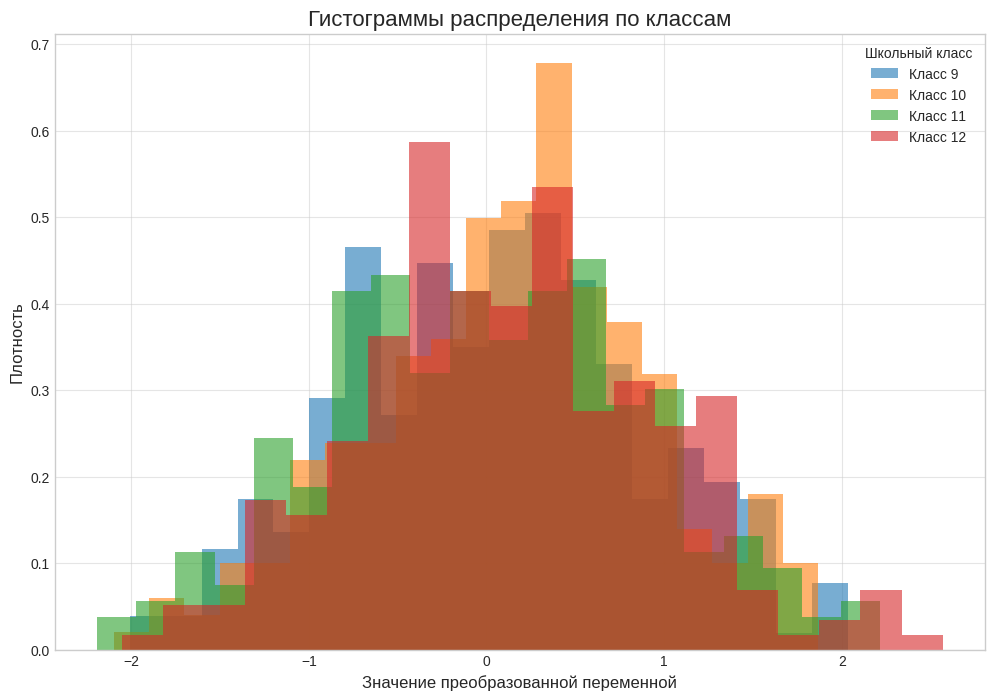

📊 Статистика по группам (школьным классам)
               mean    var  count
School_Grade                     
9             0.039  0.702    255
10            0.139  0.624    253
11           -0.003  0.774    241
12            0.128  0.692    251


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
grades = np.random.choice([9, 10, 11, 12], size=1000)
values = stats.boxcox(np.random.lognormal(size=1000) + 0.1)[0]
df = pd.DataFrame({'School_Grade': grades})
best_data = pd.Series(values, name='Transformed_Data')

df['Transformed_Data'] = best_data.values

grouped_data = df.groupby('School_Grade')['Transformed_Data']


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

for grade, group_values in grouped_data:
    plt.hist(group_values.dropna(), bins=20, alpha=0.6,
             label=f'Класс {grade}', density=True)

plt.title('Гистограммы распределения по классам', fontsize=16)
plt.xlabel('Значение преобразованной переменной', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(title='Школьный класс')
plt.grid(True, alpha=0.5)
plt.show()


group_stats = grouped_data.agg(['mean', 'var', 'count']).round(3)

print("="*50)
print("📊 Статистика по группам (школьным классам)")
print("="*50)
print(group_stats)

## Краткие выводы по работе

Исходные данные были крайне далеки от нормальных. Основные причины — сильная положительная асимметрия (≈5.4) и аномально большое количество нулевых значений. Все тесты на нормальность были провалены.

Обработка данных была частично успешной. Преобразование Бокса-Кокса эффективно устранило асимметрию (снизив её до ≈0.13), но не смогло сделать данные нормальными. Фундаментальная проблема насыщенности нулями осталась, что подтвердили итоговые тесты и Q-Q plot.

Групповой анализ показал, что распределение данных заметно отличается в зависимости от школьного класса, что говорит о неоднородности выборки.

<br>

---

## Итог
Данные имеют сложную, насыщенную нулями структуру. Стандартные преобразования могут исправить асимметрию, но не способны сделать такое распределение нормальным.